In [22]:
import numpy as np
import pandas as pd
import os
## 忽略警告
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [23]:
read_path="data/local_data/"
file_list = os.listdir(read_path)

file_list.sort()
# file_list = file_list[:10]
# file_list = file_list[:10]
# 创建一个空字典
data_dict = {}
column_mapping = {
'数据时间': 'time',
'车速': 'vehicle_speed',
'车辆状态': 'vehicle_status',
'充电状态': 'charge_status',
'累计里程': 'mileage',
'总电压': 'total_voltage',
'总电流': 'total_current',
'SOC': 'soc',
'电池单体电压最高值': 'max_single_cell_voltage',
'电池单体电压最低值': 'min_single_cell_voltage',
'最高温度值': 'max_temperature',
'最低温度值': 'min_temperature',
'驱动电机控制器温度': 'drive_motor_controller_temperature',
'驱动电机转速': 'drive_motor_speed',
'驱动电机转矩': 'drive_motor_torque',
'驱动电机温度': 'drive_motor_temperature',
'电机控制器输入电压': 'motor_controller_input_voltage',
'电机控制器直流母线电流': 'motor_controller_dc_bus_current',
'可充电储能装置电流': 'rechargeable_energy_storage_device_current'
}
feature_columns = ['vehicle_speed', 'vehicle_status', 'charge_status', 'mileage',
    'total_voltage', 'total_current', 'soc',
    'max_single_cell_voltage', 'min_single_cell_voltage', 'max_temperature',
    'min_temperature', 'drive_motor_controller_temperature',
    'drive_motor_speed', 'drive_motor_torque', 'drive_motor_temperature',
    'motor_controller_input_voltage', 'motor_controller_dc_bus_current',
    'rechargeable_energy_storage_device_current']
    
# 循环遍历所有文件
for file_name in file_list:
    # 读取数据集
    dispose_path = os.path.join(read_path , file_name)
    #读取所有子表格的数据然后合并
    data_1 = pd.read_excel(dispose_path, sheet_name=0, index_col=0)
    data_2 = pd.read_excel(dispose_path, sheet_name=1, index_col=0)
    data_3 = pd.read_excel(dispose_path, sheet_name=2, index_col=0)['可充电储能装置电流']
    # 合并数据，根据data_1的索引进行合并
    data = pd.concat([data_1, data_2, data_3], axis=1).loc[data_1.index,:]
    print("正在处理文件：{}".format(dispose_path))
    # 根据文件名和 CLX 字段确定车辆编号
    car_id = file_name.split('_')[0]
    # 修改列名
    data = data.rename(columns=column_mapping)


    ## 填充 nan 值
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    # 如果该车辆的数据在字典中已存在，则将新的数据添加到其中
    if car_id in data_dict:
        data_dict[car_id] = pd.concat([data_dict[car_id], data])
    # 如果该车辆的数据不存在，则将新的数据添加为一个新的 DataFrame
    else:
        data_dict[car_id] = data


正在处理文件：data/local_data/CL10_20220301000000_20220331235959.xlsx
正在处理文件：data/local_data/CL10_20220401000000_20220430235959.xlsx
正在处理文件：data/local_data/CL10_20220501000000_20220531235959.xlsx
正在处理文件：data/local_data/CL10_20220601000000_20220630235959.xlsx
正在处理文件：data/local_data/CL10_20220701000000_20220731235959.xlsx
正在处理文件：data/local_data/CL10_20220801000000_20220831235959.xlsx
正在处理文件：data/local_data/CL10_20220901000000_20220930235959.xlsx
正在处理文件：data/local_data/CL10_20221001000000_20221031235959.xlsx
正在处理文件：data/local_data/CL10_20221101000000_20221130235959.xlsx
正在处理文件：data/local_data/CL10_20221201000000_20221231235959.xlsx
正在处理文件：data/local_data/CL10_20230101000000_20230131235959.xlsx
正在处理文件：data/local_data/CL10_20230201000000_20230228235959.xlsx
正在处理文件：data/local_data/CL11_20220301000000_20220331235959.xlsx
正在处理文件：data/local_data/CL11_20220401000000_20220430235959.xlsx
正在处理文件：data/local_data/CL11_20220501000000_20220531235959.xlsx
正在处理文件：data/local_data/CL11_20220601000000_202206302359

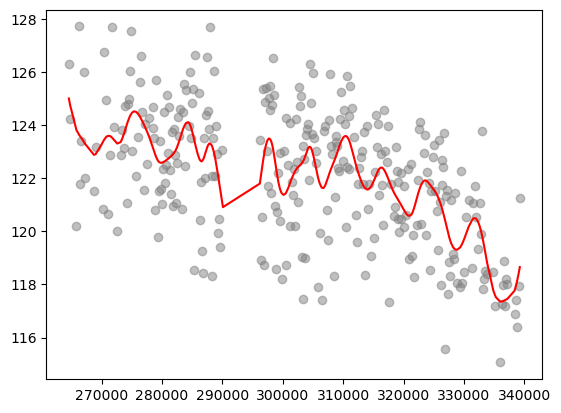

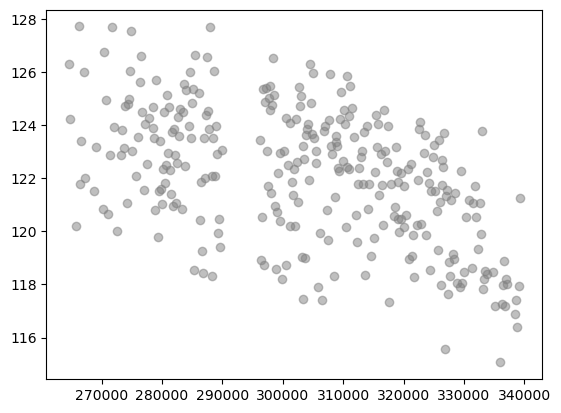

In [ ]:
from pygam import LinearGAM, s
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 对每个车辆的数据进行处理
for car_id, data in data_dict.items():
        #设置循环标记
        end_mask = (data['charge_status'].shift(2) == 1) & (data['charge_status'].shift(1) == 1) & (data['charge_status'] == 3)& (data['charge_status'].shift(-1) == 3)
        begin_mask = (data['charge_status'].shift(2) == 3) & (data['charge_status'].shift(1) == 3) & (data['charge_status'] == 1)& (data['charge_status'].shift(-1) == 1)
        data['cycle_flag'] = end_mask.cumsum()
        data['begin_charge_flag'] = begin_mask
        ## 绘制data内所有特征的曲线图
        # from matplotlib import pyplot as plt
        # data.plot(subplots=True, figsize=(16, 16))
        # plt.savefig('data/{}_data.png'.format(car_id))

        feature_data = pd.DataFrame(columns=feature_columns)
        charge_list = []
        mileage_list = []
        # 对每个充放电循环进行处理
        groups = data.groupby(data['cycle_flag'])
        for group, frame in groups:
            frame = frame.sort_index()
            charge_data = frame[frame['charge_status'] == 1]
            begin_charge_row = frame[frame['begin_charge_flag']==1]
            if charge_data.empty or begin_charge_row.empty:
                continue
            mileage = begin_charge_row['mileage'].values[0]
            ##判断soc是否是连续上升的序列，前后相差1
            soc_charge_max = min(charge_data['soc'].max(),95)
            soc_charge_min = max(charge_data['soc'].min(),25)
            soc_change_total = soc_charge_max-soc_charge_min
            ##判断charge_data_diff是不是只有1

            soc_change_max =charge_data['soc'].diff().abs().max()
            #确保soc_chargehe soc_change_max的值不为空且长度为1
            if soc_change_total>=40 and soc_change_max <= 1 and mileage>=100000:
                charge_data = charge_data[(charge_data['soc']>=25) & (charge_data['soc']<= 95)]
                # charge_data_filtered = charge_data[charge_data.diff().sum(axis=1) != 0]
                charge_energy = abs(1/180 *charge_data['total_current'].sum())/soc_change_total*100
                frame['charge_energy'] = charge_energy
                feature_data = feature_data.append(frame)
                charge_list.append(charge_energy)
                mileage_list.append(mileage)
                # frame.plot(subplots=True, figsize=(16, 16))
                # plt.savefig('data/{}_{}_data.png'.format(car_id, group))
            else:
                continue
            #绘制每个循环的曲线图
        #如果没有充电循环，则跳过
        if len(charge_list) == 0:
            continue
        else:
            charge = np.array(charge_list)
            mileage = np.array(mileage_list)
            mileage_len = mileage[-1]-mileage[0]
            n_split = max(int(mileage_len/1000),4)
            energy_data = pd.DataFrame({'charge_energy':charge, 'mileage':mileage})

            ##过滤数据
            # 计算线性回归线
            model = LinearRegression()
            model.fit(energy_data[['mileage']], energy_data['charge_energy'])
            energy_data['predicted_charge_energy'] = model.predict(energy_data[['mileage']])

            # 计算每个数据点与线性回归线的距离
            energy_data['residual'] = abs(energy_data['charge_energy'] - energy_data['predicted_charge_energy'])

            # 定义离群值的阈值
            threshold = energy_data['residual'].quantile(0.95)

            
            # 去除离群值
            energy_data = energy_data[energy_data['residual'] <= threshold]
            
            
            # 创建并拟合模型s
            gam = LinearGAM(s(0,n_splines=n_split)).fit(energy_data[['mileage']], energy_data['charge_energy'])

            # 创建平滑后的预测值s
            smoothed_capacity = gam.predict(mileage)

            # for i,frame in enumerate(feature_data):
            #     frame['smoothed_charge_energy'] = smoothed_capacity[i]
            
            # 绘制原始数据和平滑后的数据
            plt.figure()
            plt.scatter(energy_data['mileage'], energy_data['charge_energy'], color='gray', alpha=0.5)
            plt.plot(mileage, smoothed_capacity, color='red')
            plt.show()
            for i in range(len(charge_list)):
                feature_data.loc[feature_data['charge_energy'] == charge_list[i], 'fixed_capacity'] = smoothed_capacity[i]
            #在feature_data中增加一列，对应的charge_energy和smoothed_capacity
            feature_data = feature_data[feature_data['charge_energy'].isin(energy_data['charge_energy'])]
            feature_data_plot = feature_data[feature_data['begin_charge_flag'] == 1]
            plt.figure()
            plt.scatter(feature_data_plot['mileage'], feature_data_plot['charge_energy'], color='gray', alpha=0.5)
            plt.show()